In [1]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import numpy as np
import logging
snscolors = sns.color_palette("colorblind")
from copy import deepcopy

In [2]:
from cosmicfishpie.fishermatrix import cosmicfish
from cosmicfishpie.LSSsurvey import spectro_obs as spobs
from cosmicfishpie.LSSsurvey import spectro_cov as spcov
from cosmicfishpie.utilities.utils import printing as upr
from cosmicfishpie.utilities import legendre_tools as lgt

In [3]:
from numpy.polynomial import legendre as leg
from scipy.special import eval_legendre
from scipy.integrate import simpson
from scipy.interpolate import make_interp_spline
from nautilus import Prior
from nautilus import Sampler
import corner

In [4]:
from collections.abc import Sequence

def is_indexable_iterable(var):
    return isinstance(var, (list, np.ndarray, Sequence)) and not isinstance(var, (str, bytes))


In [5]:
logger = logging.getLogger("cosmicfishpie.cosmology.nuisance")
logger.setLevel(logging.INFO)

In [6]:
upr.debug = False

In [7]:
upr.debug_print("test")

In [8]:
fiducial = {
    "Omegam": 0.3145714273,
    "Omegab": 0.0491989,
    "h": 0.6737,
    "ns": 0.96605,
    "sigma8": 0.81,
    "w0": -1.0,
    "wa": 0.0,
    "mnu": 0.06,
    "Neff": 3.044,
}
observables = ['IM']

In [9]:
options = {
    "accuracy": 1,
    "feedback": 1,
    "code": "symbolic",
    "outroot": "GCIM",
    "survey_name": "SKAO",
    #"survey_name_spectro": "SKAO-Spectroscopic-Redbook",
    "survey_name_spectro": "Euclid-Spectroscopic-ISTF-Pessimistic-sigma_pv",
    "survey_name_photo": False,
    "survey_name_radio_IM": "SKAO-IM-Redbook",
    'specs_dir': '../cosmicfishpie/configs/other_survey_specifications/',
    "cosmo_model": "LCDM",
    "bfs8terms": False,
}
cosmoFM_fid = cosmicfish.FisherMatrix(
    fiducialpars=fiducial,
    options=options,
    observables=observables,
    cosmoModel=options["cosmo_model"],
    surveyName=options["survey_name"],
)

****************************************************************
   _____               _     _____     __  
  / ___/__  ___ __ _  (_)___/ __(_)__ / /  
 / /__/ _ \(_-</  ' \/ / __/ _// (_-</ _ \ 
 \___/\___/___/_/_/_/_/\__/_/ /_/___/_//_/ 

****************************************************************
 This is the new Python version of the CosmicFish code.
****************************************************************

  -> Survey loaded:  SKAO-IM-Redbook

  -> Survey loaded:  Euclid-Spectroscopic-ISTF-Pessimistic-sigma_pv

  -> No photo survey passed, returning empty dict

  -> Survey loaded:  False

  -> Computing cosmology at the fiducial point

  ---> Cosmological functions obtained in:   0.12 s


In [10]:
cosmoFM_fid.freeparams

{'Omegam': 0.01,
 'Omegab': 0.01,
 'h': 0.01,
 'ns': 0.01,
 'sigma8': 0.01,
 'bI_c1': 0.0001,
 'bI_c2': 0.0001}

In [11]:
cosmoFM_fid.Spectrobiaspars

{'lnbg_1': 0.37944989,
 'lnbg_2': 0.4738057,
 'lnbg_3': 0.55760176,
 'lnbg_4': 0.64125687}

In [12]:
cosmoFM_fid.Spectrononlinpars

{}

In [13]:
cosmoFM_fid.set_pk_settings()

spectro_fid = spobs.ComputeGalSpectro(cosmoFM_fid.fiducialcosmopars,
                                       spectrobiaspars=cosmoFM_fid.Spectrobiaspars,
                                       spectrononlinearpars=cosmoFM_fid.Spectrononlinpars,
                                       PShotpars=cosmoFM_fid.PShotpars,
                                       IMbiaspars=cosmoFM_fid.IMbiaspars,
                                       fiducial_cosmo=cosmoFM_fid.fiducialcosmo,
                                       use_bias_funcs=False, 
                                       configuration=cosmoFM_fid)

spectro_cov_fid = spcov.SpectroCov(fiducialpars=cosmoFM_fid.fiducialcosmopars,
                                   configuration=cosmoFM_fid)


volume_surveys = np.array([spectro_cov_fid.volume_survey(ii) for ii in range(len(spectro_cov_fid.global_z_bin_mids))])

In [14]:
volume_surveys

array([1.50098194e+10, 2.11302888e+10, 2.62696353e+10, 3.03122260e+10,
       3.33396310e+10, 5.38470857e+10, 3.74939849e+10, 3.81811235e+10,
       3.84954040e+10, 3.85184892e+10])

In [15]:
spectro_fid.observed_Pgg(1.0, cosmoFM_fid.Pk_kmesh, cosmoFM_fid.Pk_mumesh).shape

(9, 513)

In [16]:
vary_params = deepcopy(cosmoFM_fid.fiducialcosmopars)
print(vary_params)
vary_params['Omegam'] = 0.316
#vary_params['h'] = 0.7

{'Omegam': 0.3145714273, 'Omegab': 0.0491989, 'h': 0.6737, 'ns': 0.96605, 'sigma8': 0.81, 'w0': -1.0, 'wa': 0.0, 'mnu': 0.06, 'Neff': 3.044}


In [17]:
spectro_vary = spobs.ComputeGalSpectro(vary_params,
                                       spectrobiaspars=cosmoFM_fid.Spectrobiaspars,
                                       spectrononlinearpars=cosmoFM_fid.Spectrononlinpars,
                                       PShotpars=cosmoFM_fid.PShotpars,
                                       fiducial_cosmo=cosmoFM_fid.fiducialcosmo,
                                       use_bias_funcs=False, configuration=cosmoFM_fid)
spectro_cov_vary = spcov.SpectroCov(fiducialpars=vary_params,
                                   configuration=cosmoFM_fid,
                                   fiducial_specobs=spectro_vary)


In [18]:
spectro_cov_vary.noisy_P_ij(1.0, cosmoFM_fid.Pk_kmesh, cosmoFM_fid.Pk_mumesh, 
                            si=spectro_vary.obs_spectrum[0], 
                            sj=spectro_vary.obs_spectrum[1]).shape


(9, 513)

In [19]:
def observable_Pgg(vary_spectro, nuisance_shot=None):
    z_bins = spectro_cov_fid.global_z_bin_mids
    n_bins = len(z_bins)
    si, sj = spectro_fid.obs_spectrum
    if nuisance_shot is None:
        nuisance_shot = np.zeros_like(z_bins)
    obs_Pgg = np.zeros((n_bins, cosmoFM_fid.Pk_musamp, cosmoFM_fid.Pk_ksamp))
    for ii in range(n_bins):
        obs_Pgg[ii, :, :] = (vary_spectro.noisy_P_ij(z_bins[ii], 
                                                      cosmoFM_fid.Pk_kmesh, 
                                                      cosmoFM_fid.Pk_mumesh, 
                                                      si=si, sj=sj)
                                                      + nuisance_shot[ii])
    return obs_Pgg

multipole_order = 4
leg_ells = np.arange(0, multipole_order+1, 2 , dtype='int')
def legendre_Pgg(obs_Pgg):
    legendre_vals = eval_legendre(leg_ells[None, :], cosmoFM_fid.Pk_mugrid[:, None])
    legendre_vals = legendre_vals[None, :, None, :]
    obsPgg_forleg = obs_Pgg[:, :, :, None]
    P_ell = ((2. * leg_ells[None,None,:] + 1)) * simpson(legendre_vals * obsPgg_forleg, 
                                                        x=cosmoFM_fid.Pk_mugrid, axis=1)
    P_ell = P_ell.transpose(1, 0, 2)
    return P_ell

In [20]:
obsPgg_fid = observable_Pgg(spectro_cov_fid)
obsPgg_fid.shape

(10, 9, 513)

In [21]:
spectro_vary.Temperature(1.0)**2

0.02976623107414456

In [22]:
obsPgg_fid[0, 0, :]

array([171.14805964, 171.28442833, 218.32872339, 262.57258576,
       304.03879663, 342.77996402, 378.87053473, 412.3984012 ,
       443.4598703 , 472.15597049, 498.5898523 , 522.86493016,
       545.08352939, 565.345877  , 583.74932959, 600.38780171,
       615.351328  , 628.72576191, 640.59258794, 651.02880058,
       660.10695359, 667.89524325, 674.45764917, 679.85423878,
       684.14149114, 687.37257017, 689.59781227, 690.86515435,
       691.22048672, 690.70810349, 689.37107589, 687.25146716,
       684.39089775, 680.83047462, 676.6109295 , 671.77297136,
       666.35699165, 660.40304339, 653.9510288 , 647.04021637,
       639.70921191, 631.99578208, 623.9366779 , 615.56746869,
       606.92239495, 598.03424613, 588.93426705, 579.65209454,
       570.21572402, 560.65144315, 550.98398087, 541.23656042,
       531.43077073, 521.58677261, 511.72344955, 501.85826124,
       492.00758463, 482.18660713, 472.40946777, 462.68935433,
       453.03842525, 443.46820095, 433.98905187, 424.61

In [23]:
obsPgg_vary = observable_Pgg(spectro_cov_vary)
obsPgg_vary.shape

(10, 9, 513)

In [24]:
P_ell_fid = legendre_Pgg(obsPgg_fid)
P_ell_fid.shape

(513, 10, 3)

In [25]:
P_ell_vary = legendre_Pgg(obsPgg_vary)
P_ell_vary.shape

(513, 10, 3)

In [26]:
spectro_cov_fid.global_z_bin_mids


array([0.6 , 0.8 , 1.  , 1.2 , 1.4 , 1.65, 1.9 , 2.1 , 2.3 , 2.5 ])

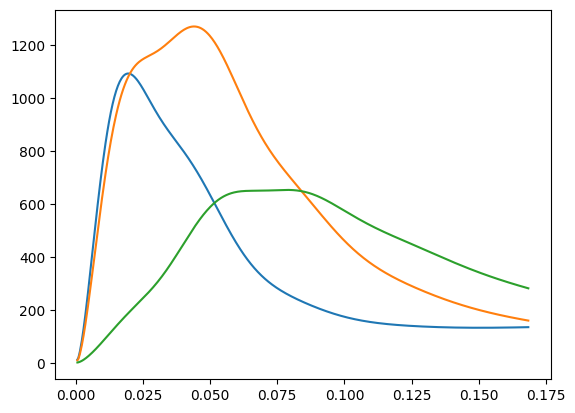

In [27]:
kk = spectro_cov_fid.config.Pk_kgrid
plt.plot(kk, kk*P_ell_fid[:, 0, 0]/spectro_fid.Temperature(spectro_cov_fid.global_z_bin_mids[0])**2)
plt.plot(kk, kk*P_ell_fid[:, 0, 1]/spectro_fid.Temperature(spectro_cov_fid.global_z_bin_mids[0])**2)
plt.plot(kk, kk*P_ell_fid[:, 0, 2]/spectro_fid.Temperature(spectro_cov_fid.global_z_bin_mids[0])**2)

In [28]:
def compute_covariance_legendre(P_ell, volume_survey):
    """
    Compute covariance matrix for power spectrum multipoles
    P_ell shape: (n_k, n_z, n_ell)
    """
    k_grid = spectro_cov_fid.config.Pk_kgrid
    P_ell_broad = P_ell[:, :, :, None, None]
    n_k, n_z, n_ell = P_ell.shape
    
    # Compute auto and cross terms
    P00 = (P_ell_broad[:, :, 0])**2 * lgt.m00[None, None, :, :]
    P22 = (P_ell_broad[:, :, 1])**2 * lgt.m22[None, None, :, :]
    P44 = (P_ell_broad[:, :, 2])**2 * lgt.m44[None, None, :, :]
    
    P02 = P_ell_broad[:, :, 0] * P_ell_broad[:, :, 1] * lgt.m02[None, None, :, :]
    P24 = P_ell_broad[:, :, 1] * P_ell_broad[:, :, 2] * lgt.m24[None, None, :, :]
    P04 = P_ell_broad[:, :, 0] * P_ell_broad[:, :, 2] * lgt.m04[None, None, :, :]
    
    # Compute mode-by-mode covariance
    mode_by_mode_covariance = (
        2 * (2 * leg_ells[None, None, :, None] + 1) *
        (2 * leg_ells[None, None, None, :] + 1) / 
        volume_survey[None, :, None, None] *
        (P00 + P22 + P44 + 2*P02 + 2*P24 + 2*P04)
    )
    ln_k_grid = np.log(k_grid)
    k_size = len(k_grid)
    if n_k != k_size:
        raise ValueError("k_grid and P_ell have different lengths in k")
    ln_k_bin_edges = np.zeros((k_size + 1 ), 'float64')
    ln_k_bin_edges[1:-1] = (ln_k_grid[1:] + ln_k_grid[:-1])/2.
    ln_k_bin_edges[0] = ln_k_bin_edges[1] - (ln_k_grid[1] - ln_k_grid[0])
    ln_k_bin_edges[-1] = ln_k_bin_edges[-2] + (ln_k_grid[-1] - ln_k_grid[-2])
    k_bin_volume = 4*np.pi/3. * np.diff(np.exp(3 * ln_k_bin_edges)) 
    # Multiply by k^3 factor
    covariance_integrand = mode_by_mode_covariance * (k_grid[:, None, None, None])**3
    covariance_integrand_spline = make_interp_spline(ln_k_grid, covariance_integrand, k=1, axis=0)

    #We create an array into which we fill the values for the covmat. We integrate over the ln_k_bin_edges
    covariance = np.zeros((k_size, n_z, n_ell, n_ell),'float64')
    for index_k in range(k_size):
        covariance[index_k,:,:,:] = covariance_integrand_spline.integrate(ln_k_bin_edges[index_k],ln_k_bin_edges[index_k+1])

    #We multiply the covariance matrix by this factor
    covariance *= 2*(2*np.pi)**4 /((k_bin_volume[:, None, None, None])**2)

    #We need the inverse of the covariance matrix for the chi2 computation
    inv_covariance = np.linalg.inv(covariance) 
    
    return covariance, inv_covariance


In [29]:
covariance_leg, inv_covariance_leg = compute_covariance_legendre(
    P_ell=P_ell_fid,  # From legendre_Pgg function
    volume_survey=volume_surveys
)

In [30]:
def compute_chi2_legendre(P_ell_fid, P_ell, inv_covariance):
    """
    Compute χ² using broadcasting
    
    P_ell_fid: shape (n_k, n_z, n_ell)
    P_ell: shape (n_k, n_z, n_ell)
    inv_covariance: shape (n_k, n_z, n_ell, n_ell)
    """
    
    chi2 = np.sum((P_ell_fid[...,None] - P_ell[...,None]) * 
                  inv_covariance * 
                  (P_ell_fid[...,None,:] - P_ell[...,None,:]))
    
    return chi2

In [31]:
compute_chi2_legendre(P_ell_fid, P_ell_vary, inv_covariance_leg)


1.9057053067803382

In [32]:
def compute_wedge_chi2(P_obs_fid, P_obs, volume_survey):
    """
    Compute χ² for wedges using fully vectorized operations.
    Matches the loop implementation exactly.
    
    Parameters:
    ----------
    P_obs_fid : array_like
        Fiducial power spectrum (n_z, n_mu, n_k)
    P_obs : array_like
        Observed power spectrum (n_z, n_mu, n_k)
    volume_survey : array_like
        Fiducial volumes (volume_surveys)
    
    Returns:
    -------
    float
        χ² value
    """

    k_grid = spectro_cov_fid.config.Pk_kgrid
    mu_grid = spectro_cov_fid.config.Pk_mugrid
    prefactor = (8 * np.pi**2)
    
    # Compute delta (n_z, n_mu, n_k)
    delta = P_obs - P_obs_fid
    
    # Prepare terms for broadcasting:
    k_term = k_grid[None, None, :] ** 2      # (1, 1, n_k)
    V_term = volume_survey[:, None, None]            # (n_z, 1, 1)
    
    # Compute covariance (n_z, n_mu, n_k)
    covariance = (prefactor / (k_term * V_term)) * P_obs_fid**2
    
    # Compute k_integrand for all points simultaneously
    k_integrand = delta**2 / covariance
    
    # Integrate over k for all z and mu (n_z, n_mu)
    mu_integrand = 2 * simpson(k_integrand, x=k_grid, axis=2)  # Factor 2 for mu-symmetry
    
    # Integrate over mu for all z (n_z)
    z_integrand = simpson(mu_integrand, x=mu_grid, axis=1)
    
    # Sum over z bins
    chi2 = np.sum(z_integrand)
    
    # print(f'Max of k_integrand: {np.max(k_integrand)}')
    # print(f'Min of k_integrand: {np.min(k_integrand)}')
    
    return chi2

# Usage:
chi2_wedges = compute_wedge_chi2(
    P_obs_fid=obsPgg_fid,  
    P_obs=obsPgg_vary,     
    volume_survey=volume_surveys
)
print("euclid_spectroscopic in wedges_mode: chi2 =", chi2_wedges)

euclid_spectroscopic in wedges_mode: chi2 = 1.3863277118001274


In [33]:
cosmoFM_fid.Spectrobiaspars

{'lnbg_1': 0.37944989,
 'lnbg_2': 0.4738057,
 'lnbg_3': 0.55760176,
 'lnbg_4': 0.64125687}

In [34]:
cosmoFM_fid.PShotpars

{}

In [35]:
cosmoFM_fid.Spectrononlinpars

{}

In [36]:
spectro_fid.obs_spectrum

['I', 'I']

In [37]:
def loglike(param_vec, prior=None, leg_flag='wedges'):

    z_bins = spectro_cov_fid.global_z_bin_mids
    
    if type(param_vec) == dict:
        param_dict = deepcopy(param_vec)
    elif is_indexable_iterable(param_vec) and prior is not None:
        #print(f'Loading prior with keys: {prior.keys}')
        param_dict={key: param_vec[i] for i, key in enumerate(prior.keys)}
    
    nuisance_shot = np.zeros(len(z_bins))
    pshotpars = deepcopy(cosmoFM_fid.PShotpars)
    for ii, pp in enumerate(pshotpars.keys()):
        nuisance_shot[ii] = param_dict.pop(pp, cosmoFM_fid.PShotpars[pp])
    
    spectrobiaspars = deepcopy(cosmoFM_fid.Spectrobiaspars)
    for ii, pp in enumerate(spectrobiaspars.keys()):
        spectrobiaspars[pp] = param_dict.pop(pp, cosmoFM_fid.Spectrobiaspars[pp])
    
    spectrononlinearpars = deepcopy(cosmoFM_fid.Spectrononlinpars)
    for ii, pp in enumerate(spectrononlinearpars.keys()):
        spectrononlinearpars[pp] = param_dict.pop(pp, cosmoFM_fid.Spectrononlinpars[pp])

    IMbiaspars = deepcopy(cosmoFM_fid.IMbiasparams)
    for pp in IMbiaspars.keys():
        IMbiaspars[pp] = param_dict.pop(pp, cosmoFM_fid.IMbiasparams[pp])
    
    spectro_vary = spobs.ComputeGalSpectro(param_dict,
                                           spectrobiaspars=spectrobiaspars,
                                           spectrononlinearpars=spectrononlinearpars,
                                           PShotpars=cosmoFM_fid.PShotpars,
                                           fiducial_cosmo=cosmoFM_fid.fiducialcosmo,
                                           IMbiaspars=IMbiaspars,
                                           use_bias_funcs=False, configuration=cosmoFM_fid)
    spectro_cov_vary = spcov.SpectroCov(fiducialpars=param_dict,
                                   configuration=cosmoFM_fid,
                                   fiducial_specobs=spectro_vary)
    obsPgg_vary = observable_Pgg(spectro_cov_vary, nuisance_shot=nuisance_shot)
    
    if leg_flag == 'wedges':
        chi2 = compute_wedge_chi2(
                                  P_obs_fid=obsPgg_fid,  
                                  P_obs=obsPgg_vary,     
                                  volume_survey=volume_surveys
                                )
    elif leg_flag == 'legendre':
        P_ell_vary = legendre_Pgg(obsPgg_vary)
        covariance_leg, inv_covariance_leg = compute_covariance_legendre(
            P_ell=P_ell_fid,  # Test later with P_ell_vary
            volume_survey=volume_surveys
        )
        chi2 = compute_chi2_legendre(P_ell_fid, P_ell_vary, inv_covariance_leg)
    return -0.5 * chi2

In [38]:
fiducial

{'Omegam': 0.3145714273,
 'Omegab': 0.0491989,
 'h': 0.6737,
 'ns': 0.96605,
 'sigma8': 0.81,
 'w0': -1.0,
 'wa': 0.0,
 'mnu': 0.06,
 'Neff': 3.044}

In [39]:
cosmoFM_fid.freeparams

{'Omegam': 0.01,
 'Omegab': 0.01,
 'h': 0.01,
 'ns': 0.01,
 'sigma8': 0.01,
 'bI_c1': 0.0001,
 'bI_c2': 0.0001}

In [40]:
cosmoFM_fid.allparams

{'Omegam': 0.3145714273,
 'Omegab': 0.0491989,
 'h': 0.6737,
 'ns': 0.96605,
 'sigma8': 0.81,
 'w0': -1.0,
 'wa': 0.0,
 'mnu': 0.06,
 'Neff': 3.044,
 'fout': 0.1,
 'co': 1,
 'cb': 1,
 'sigma_o': 0.05,
 'sigma_b': 0.05,
 'zo': 0.1,
 'zb': 0.0,
 'IA_model': 'eNLA',
 'AIA': 1.72,
 'betaIA': 2.17,
 'etaIA': -0.41,
 'lnbg_1': 0.37944989,
 'lnbg_2': 0.4738057,
 'lnbg_3': 0.55760176,
 'lnbg_4': 0.64125687,
 'bI_c1': 0.3,
 'bI_c2': 0.6}

In [41]:
fid_truth = {par : cosmoFM_fid.allparams[par] for par in cosmoFM_fid.freeparams.keys()}
fid_truth


{'Omegam': 0.3145714273,
 'Omegab': 0.0491989,
 'h': 0.6737,
 'ns': 0.96605,
 'sigma8': 0.81,
 'bI_c1': 0.3,
 'bI_c2': 0.6}

In [42]:
samp1dic = {'Omegam': 0.31,
            'Omegab': 0.05,
            'h': 0.68,
            'ns': 0.96,
            'sigma8': 0.82,
            'w0': -1.01,
            'wa': 0.2,
            'Ps_0': 0.0,
            'Ps_1': 0.0,
            'Ps_2': 0.0,
            'Ps_3': 10.0,
            'lnbg_1': 0.37944989,
            'lnbg_2': 0.4738057,
            'lnbg_3': 0.55760176,
            'lnbg_4': 0.6,
            'sigmap_1': 1.0,
            'sigmap_2': 0.,
            'sigmap_3': 1.0,
            'sigmap_4': 1.0,
            'sigmav_1': 1.0,
            'sigmav_2': 1.0,
            'sigmav_3': 0.,
            'sigmav_4': 10,
            'bI_c1': -0.3,
            'bI_c2': +0.6,
            }
print("Wedges loglike: ", loglike(samp1dic))
print("Multipoles loglike: ", loglike(samp1dic, leg_flag='legendre'))

Wedges loglike:  -182788.27159966624
Multipoles loglike:  -366164.7781302942


In [43]:
prior = Prior()
prior_noshot = Prior()
prior_noshot_no_bi = Prior()
prior_nosigma = Prior()

In [44]:
prior_dict ={
 'Omegam': [0.24, 0.4],
 'Omegab': [0.04, 0.06],
 'h': [0.61, 0.73],
 'ns': [0.92, 1.00],
 'sigma8': [0.79, 0.83],
 'Ps_0': [-10, 10],
 'Ps_1': [-10, 10],
 'Ps_2': [-10, 10],
 'Ps_3': [-10, 10],
 'lnbg_1': [0, 1],
 'lnbg_2': [0, 1],
 'lnbg_3': [0, 1],
 'lnbg_4': [0, 1],
 'sigmap_1': [0, 10],
 'sigmap_2': [0, 10],
 'sigmap_3': [0, 10],
 'sigmap_4': [0, 10],
 'sigmav_1': [0, 10],
 'sigmav_2': [0, 10],
 'sigmav_3': [0, 10],
 'sigmav_4': [0, 10],
 'bI_c1': [-5, 5],
 'bI_c2': [-5, 5],
 }


In [45]:
cosmoFM_fid.freeparams

{'Omegam': 0.01,
 'Omegab': 0.01,
 'h': 0.01,
 'ns': 0.01,
 'sigma8': 0.01,
 'bI_c1': 0.0001,
 'bI_c2': 0.0001}

In [46]:
for par in prior_dict.keys():
    if par in cosmoFM_fid.freeparams.keys():
        dist_prior = (prior_dict[par][0], prior_dict[par][1])
        prior.add_parameter(par, dist_prior)
        if 'sigmap' not in par and 'sigmav' not in par:
            prior_nosigma.add_parameter(par, dist_prior)
        if 'Ps' not in par and ('sigmap' not in par and 'sigmav' not in par):
            prior_noshot.add_parameter(par, dist_prior)
        if 'Ps' not in par and 'lnbg' not in par and ('sigmap' not in par and 'sigmav' not in par):
            prior_noshot_no_bi.add_parameter(par, dist_prior)

In [47]:
print('Loaded prior into Nautilus with dimension',prior.dimensionality())
print('Loaded prior into Nautilus with dimension',prior_noshot.dimensionality())
print('Loaded prior into Nautilus with dimension',prior_noshot_no_bi.dimensionality())
print('Loaded prior into Nautilus with dimension',prior_nosigma.dimensionality())
print('Prior keys: ',prior.keys)
print('Prior keys noshot: ',prior_noshot.keys)
print('Prior keys noshot no bi: ',prior_noshot_no_bi.keys)
print('Prior keys nosigma: ',prior_nosigma.keys)

Loaded prior into Nautilus with dimension 7
Loaded prior into Nautilus with dimension 7
Loaded prior into Nautilus with dimension 7
Loaded prior into Nautilus with dimension 7
Prior keys:  ['Omegam', 'Omegab', 'h', 'ns', 'sigma8', 'bI_c1', 'bI_c2']
Prior keys noshot:  ['Omegam', 'Omegab', 'h', 'ns', 'sigma8', 'bI_c1', 'bI_c2']
Prior keys noshot no bi:  ['Omegam', 'Omegab', 'h', 'ns', 'sigma8', 'bI_c1', 'bI_c2']
Prior keys nosigma:  ['Omegam', 'Omegab', 'h', 'ns', 'sigma8', 'bI_c1', 'bI_c2']


In [48]:
print("Loading prior with keys: ", prior.keys)
sampler = Sampler(prior, 
                          loglike, 
                          n_live=1000, 
                          n_networks=4, 
                          n_batch=256, pool=8, 
                          pass_dict=False,
                          filepath='cosmicshark_SKAO-IM_Nautilus_wedges_biasfit-sympriors.hdf5', 
                          resume=True,
                          likelihood_kwargs={'leg_flag': 'wedges', 
                                             'prior': prior}
                          )
sampler.run(verbose=True, discard_exploration=True)
log_z_all = sampler.evidence()
print('Evidence:', log_z_all)
points_all, log_w_all, log_l_all = sampler.posterior()

Loading prior with keys:  ['Omegam', 'Omegab', 'h', 'ns', 'sigma8', 'bI_c1', 'bI_c2']
Starting the nautilus sampler...
Please report issues at github.com/johannesulf/nautilus.
Status    | Bounds | Ellipses | Networks | Calls    | f_live | N_eff | log Z    
Finished  | 39     | 1        | 4        | 60160    | N/A    | 10006 | -24.57   
Evidence: -24.572992005708382


/tmp/ipykernel_1028008/692526979.py:14: DeprecationWarning: The function 'evidence' is deprecated. Please use the property 'log_z', instead.
  log_z_all = sampler.evidence()


In [49]:
eq_points_all, eq_log_w_all, eq_log_l_all = sampler.posterior(equal_weight=True, 
                                  equal_weight_boost=10)


In [50]:
eq_points_all.shape

(49016, 7)

In [82]:
sample_wghlkl = (np.vstack((points_all.T, np.exp(log_w_all), log_l_all)).T)

In [83]:
np.savetxt('sample_wghlkl.txt', sample_wghlkl)

In [84]:
eq_sample_wghlkl = (np.vstack((eq_points_all.T, np.exp(eq_log_w_all), eq_log_l_all)).T)
eq_sample_wghlkl.shape

(49016, 9)

In [85]:
np.savetxt('eq_sample_wghlkl.txt', eq_sample_wghlkl)

In [86]:
import pandas as pd
nautiframe_IM = pd.DataFrame(sample_wghlkl, columns=prior.keys+['weight', 'posterior'])

In [87]:
nautieq_IM = pd.DataFrame(eq_sample_wghlkl, columns=prior.keys+['weight', 'posterior'])

In [88]:
len(prior.keys)

7

In [89]:
nautiframe_IM['weight'].values

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
       6.53936897e-05, 6.50927806e-05, 1.06361646e-04])

In [90]:

# Method 2: Using > 0 (if weights are always positive)
nonzero_df = nautiframe_IM[nautiframe_IM['weight'] > 0]


In [91]:
print(f"Original shape: {nautiframe_IM.shape}")
print(f"Filtered shape: {nonzero_df.shape}")
print("\nNon-zero weights:")
print(nonzero_df['weight'].values)

Original shape: (17408, 9)
Filtered shape: (14099, 9)

Non-zero weights:
[2.05037243e-321 1.97626258e-323 5.06819152e-312 ... 6.53936897e-005
 6.50927806e-005 1.06361646e-004]


In [92]:
fisher_IM = cosmoFM_fid.compute()


In class: FisherMatrix  ----> Computing Pk-spectro Fisher matrix
Computing derivatives of Galaxy Clustering Spectro
>> Computing Derivs >>

  +++ Computing derivative on Omegam

In class: derivatives  Derivative on Omegam done! in :  0.42 s

  +++ Computing derivative on Omegab

In class: derivatives  Derivative on Omegab done! in :  0.42 s

  +++ Computing derivative on h

In class: derivatives  Derivative on h done! in :  0.42 s

  +++ Computing derivative on ns

In class: derivatives  Derivative on ns done! in :  0.43 s

  +++ Computing derivative on sigma8

In class: derivatives  Derivative on sigma8 done! in :  0.42 s

  +++ Computing derivative on bI_c1

In class: derivatives  Derivative on bI_c1 done! in :  0.18 s

  +++ Computing derivative on bI_c2

In class: derivatives  Derivative on bI_c2 done! in :  0.18 s

In class: FisherMatrix  Fisher Matrix shape: (10, 7, 7)

  Fisher matrix calculation finished in   2.73 s

  Fisher matrix exported: ./results/CosmicFish_v1.2.0_GCIM_I

In [93]:
fisher_IM.get_confidence_bounds()
fisher_IM.get_param_names()

['Omegam', 'Omegab', 'h', 'ns', 'sigma8', 'bI_c1', 'bI_c2']

In [94]:
prior.keys

['Omegam', 'Omegab', 'h', 'ns', 'sigma8', 'bI_c1', 'bI_c2']

In [95]:
fisher_IM.name = 'CosmicFish SKAO IM'

In [96]:
fisher_IM.param_fiducial

array([0.314571, 0.049199, 0.6737  , 0.96605 , 0.81    , 0.3     ,
       0.6     ])

In [97]:
import numpy.random as npr

In [98]:
fid_truth

{'Omegam': 0.3145714273,
 'Omegab': 0.0491989,
 'h': 0.6737,
 'ns': 0.96605,
 'sigma8': 0.81,
 'bI_c1': 0.3,
 'bI_c2': 0.6}

In [99]:
from chainconsumer import Chain, ChainConsumer, make_sample, Truth, ChainConfig, PlotConfig

In [100]:
dict(zip(list(fisher_IM.get_param_names()), list(fisher_IM.get_param_names_latex())))

{'Omegam': '\\Omega_{{\\rm m}, 0}',
 'Omegab': '\\Omega_{{\\rm b}, 0}',
 'h': 'h',
 'ns': 'n_{\\rm s}',
 'sigma8': '\\sigma_8',
 'bI_c1': 'bI_c1',
 'bI_c2': 'bI_c2'}

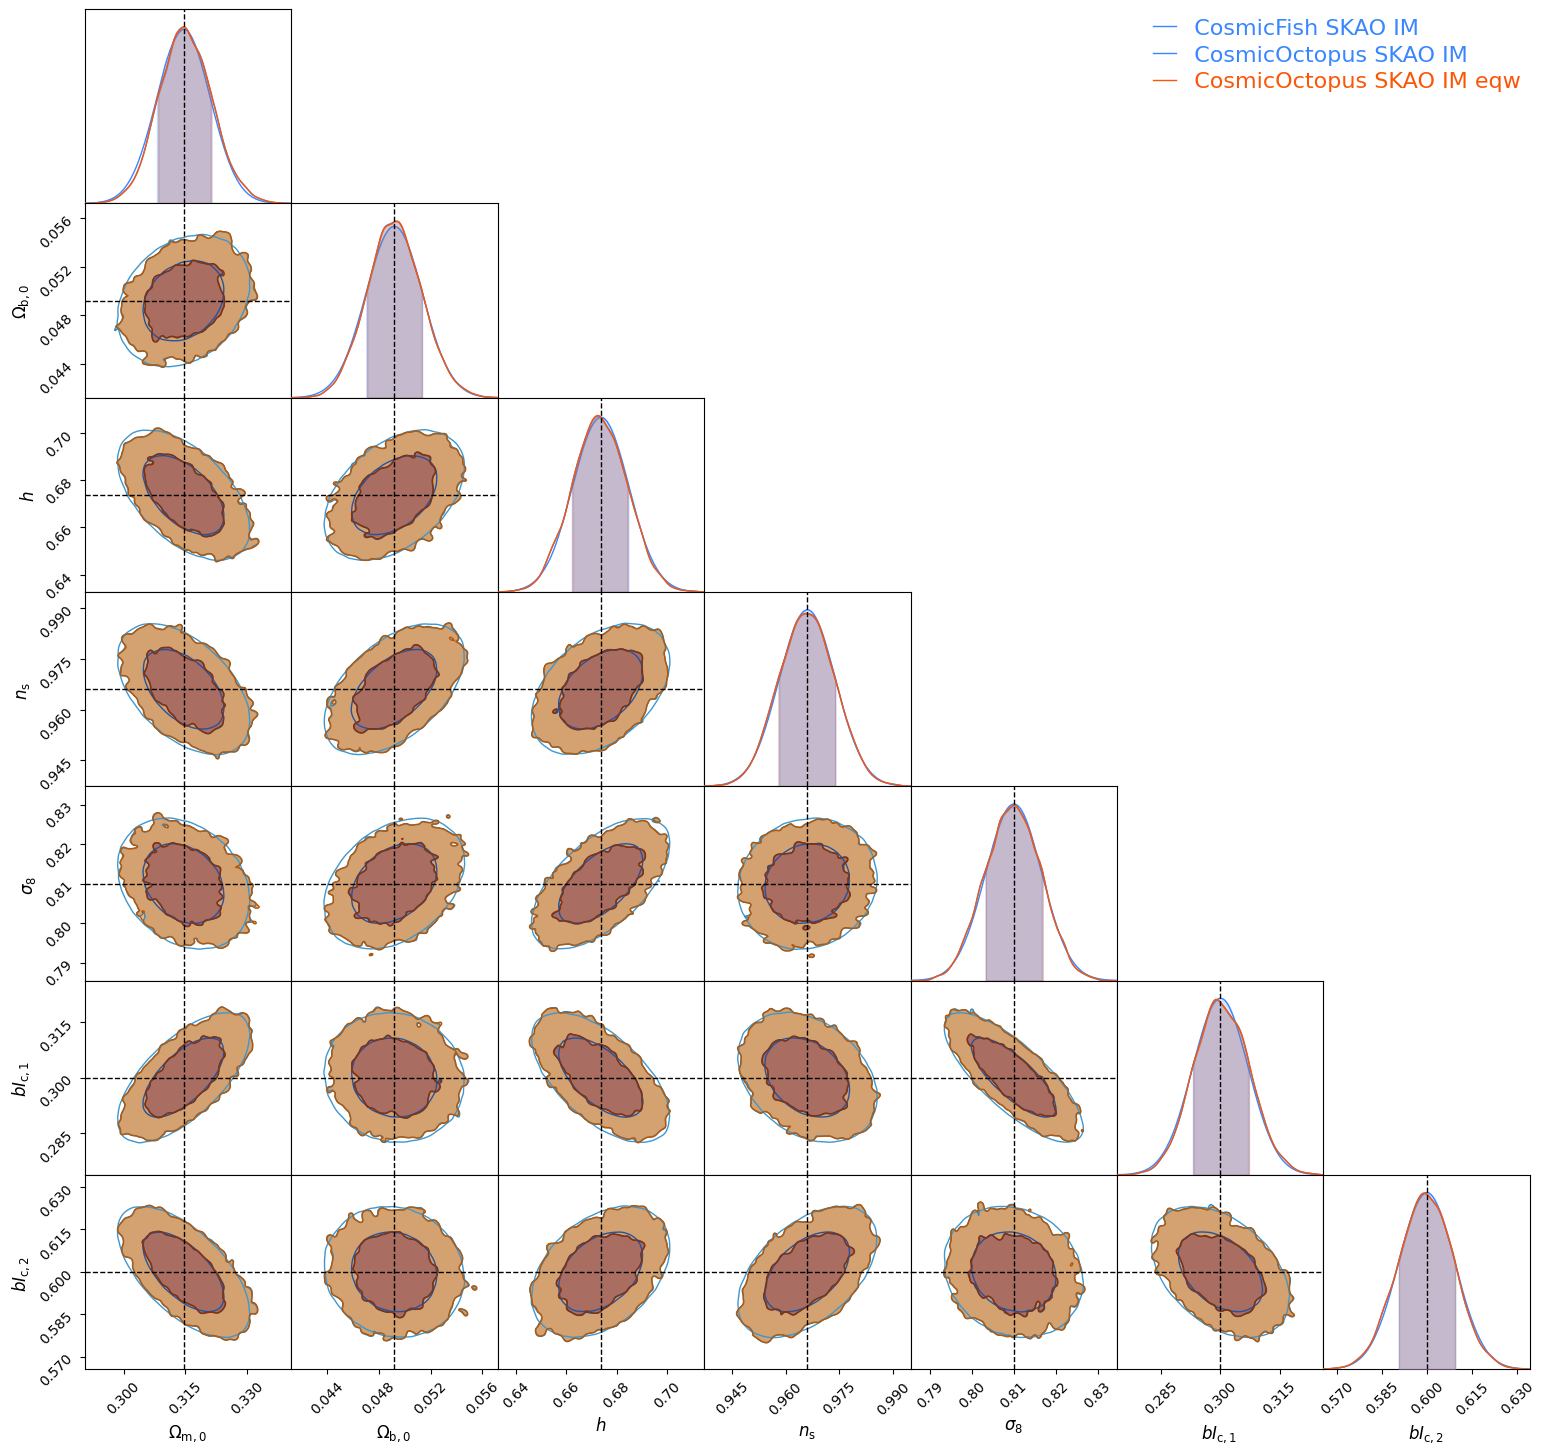

In [102]:
fishers_list = [fisher_IM]
#fishers_list = []
chains_list = [nautiframe_IM, nautieq_IM]
#chains_list = []
labels_fisher = None
labels_chain = ['CosmicOctopus SKAO IM', 'CosmicOctopus SKAO IM eqw']
#labels_chain = ['CosmicOctopus SKAO IM eqw']
n_samples = 1000000
legend = True
params_to_plot = prior.keys
shades_bools_chains = [True, True]
shades_bools_fishers = [False]
c = ChainConsumer()

# Default colors if none provided
colors = ['#3a86ff', '#fb5607', '#8338ec', '#ffbe0b', '#d11149']
# Default labels if none provided
if labels_fisher is None:
    labels_fisher = [fii.name for fii in fishers_list]
if labels_chain is None:
    labels_chain = [f'Chain #{i+1}' for i in range(len(chains_list))]

# Generate samples for each Fisher matrix
for i, fisher in enumerate(fishers_list):
    # Get samples from multivariate normal using Fisher matrix
    fishchain = Chain.from_covariance(mean=fisher.param_fiducial, 
                                      covariance=fisher.fisher_matrix_inv,
                                      columns=fisher.param_names,
                                      color=colors[i],
                                      shade=shades_bools_fishers[i],
                                      name=labels_fisher[i])
    c.add_chain(fishchain)

for j, chain in enumerate(chains_list):
    chain_nonzero = chain[chain['weight']>0]
    c.add_chain(Chain(samples=chain_nonzero,
                      name=labels_chain[j],
                      color=colors[i+j],
                      shade=shades_bools_chains[j]
                     )
    )
c.add_truth(Truth(location=fid_truth))
# Configure plot settings
c.set_plot_config(PlotConfig(
    sigma2d=False,
    summary=True,
    plot_point=True,
    legend_kwargs={"fontsize": 16},
    labels={
        'Omegam': r'$\Omega_{{\rm m}, 0}$',
        'Omegab': r'$\Omega_{{\rm b}, 0}$',
        'h': r'$h$',
        'ns': r'$n_{\rm s}$',
        'sigma8': r'$\sigma_8$',
        'bI_c1': r'$bI_{{\rm c}, 1}$',
        'bI_c2': r'$bI_{{\rm c}, 2}$'
    }
    )
    )

# Create the plot
fig = c.plotter.plot()